In [83]:
%%capture
# ! pip install -q git+https://github.com/EfficientDL/codelab_utils.git
# !pip install tensorflow-model-optimization

import tensorflow as tf
import tensorflow_datasets as tfds
# import tensorflow_models as tfm
import tensorflow_addons as tfa
import tensorflow_model_optimization as tfmot
import ipywidgets as ipyw
import numpy as np

from pathlib import Path
from tensorflow.keras import layers, optimizers, metrics, losses, models
from tensorflow.keras import applications as apps, callbacks as cbs
from tensorflow.keras.utils import plot_model, array_to_img
from matplotlib import pyplot as plt
import codelab_utils.mpl_styles as mpl_styles

mpl_styles.set_default_styles()
plt.rcParams['font.family'] = 'Poppins'

## Dataset Download

In [79]:
%%capture
(train_ds, val_ds, test_ds), ds_info = tfds.load(
    'oxford_flowers102',
    with_info=True,
    split=['train', 'validation', 'test'],
    read_config=tfds.ReadConfig(try_autocache=False)
)

## Standardize Dataset

In [80]:
# Dataset image size
IMG_SIZE = 264

# Configuration for deterministic results
SEED = 3
tf.random.set_seed(SEED)
np.random.seed(SEED)

def preprocess(item):
    image, label = item['image'], item['label']
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.uint8)
    return image, label

train_prep_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_prep_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_prep_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Input Transormations for the Contrastive Model

In [98]:
N_CLASSES = 102
SHUFFLE_BUFFER_SIZE = 500

# Augmentation Configuration
CROP_LOW_LIMIT = int(.08*IMG_SIZE)
CROP_HIGH_LIMIT = IMG_SIZE
PIXEL_MAX_VAL = 255
GAUSSIAN_KERNEL_SIZE = 23

def random_crop_and_resize(image):
    def crop():
        crop_size = tf.random.uniform(
            [],
            minval=CROP_LOW_LIMIT,
            maxval=CROP_HIGH_LIMIT+1,
            dtype=tf.int32
        )
        crop = tf.image.random_crop(image, (crop_size, crop_size, image.shape[-1]))
        return crop
    
    cropped = crop()
    resized = tf.image.resize(cropped, (IMG_SIZE, IMG_SIZE))
    return resized

"""color_jitter
    We apply transformations in the following order:
        1- Random brightness.
        2- Random contrast.
        3- Random saturation.
"""
def color_jitter(image, factor=0.8):
    minval = int(factor*PIXEL_MAX_VAL)-1
    maxval = int(factor*PIXEL_MAX_VAL)
    clip_args = [0, PIXEL_MAX_VAL]
    transformed = tf.clip_by_value(tf.image.random_brightness(image, maxval), *clip_args)
    transformed = tf.clip_by_value(tf.image.random_contrast(transformed, minval, maxval), *clip_args)
    transformed = tf.clip_by_value(tf.image.random_saturation(transformed, minval, maxval), *clip_args)

    return transformed

def gaussian_blur(image):
    blurred = tfa.image.gaussian_filter2d(
        image,
        (GAUSSIAN_KERNEL_SIZE, GAUSSIAN_KERNEL_SIZE),
        (0.1, 2.0)
    )
    return blurred

"""apply_image_transforms
    We apply transformations in the following order:
        1- Random crop and resize to the original size.
        2- Random horizontal flip.
        3- Random color jitter.
        4- Gaussian Blur
"""
def apply_image_transforms(image):
    def random_flip(x):
        return tf.image.random_flip_left_right(x)

    image = random_crop_and_resize(image)
    image = random_flip(image)
    image = color_jitter(image)
    image = gaussian_blur(image)
    return image

def make_display_input(image):
    transform1, transform2 = apply_image_transforms(image), apply_image_transforms(image)
    return image, transform1, transform2

def make_contrastive_input(image, label):
    transform1, transform2 = apply_image_transforms(image), apply_image_transforms(image)
    inputs = tf.stack([transform1, transform2], axis=0)
    labels = tf.stack([label, label], axis=0)
    return inputs, labels

train_contrastive_ds = train_prep_ds.shuffle(
    SHUFFLE_BUFFER_SIZE,
    reshuffle_each_iteration=True
)
train_contrastive_ds = train_contrastive_ds.map(make_contrastive_input).unbatch()

35


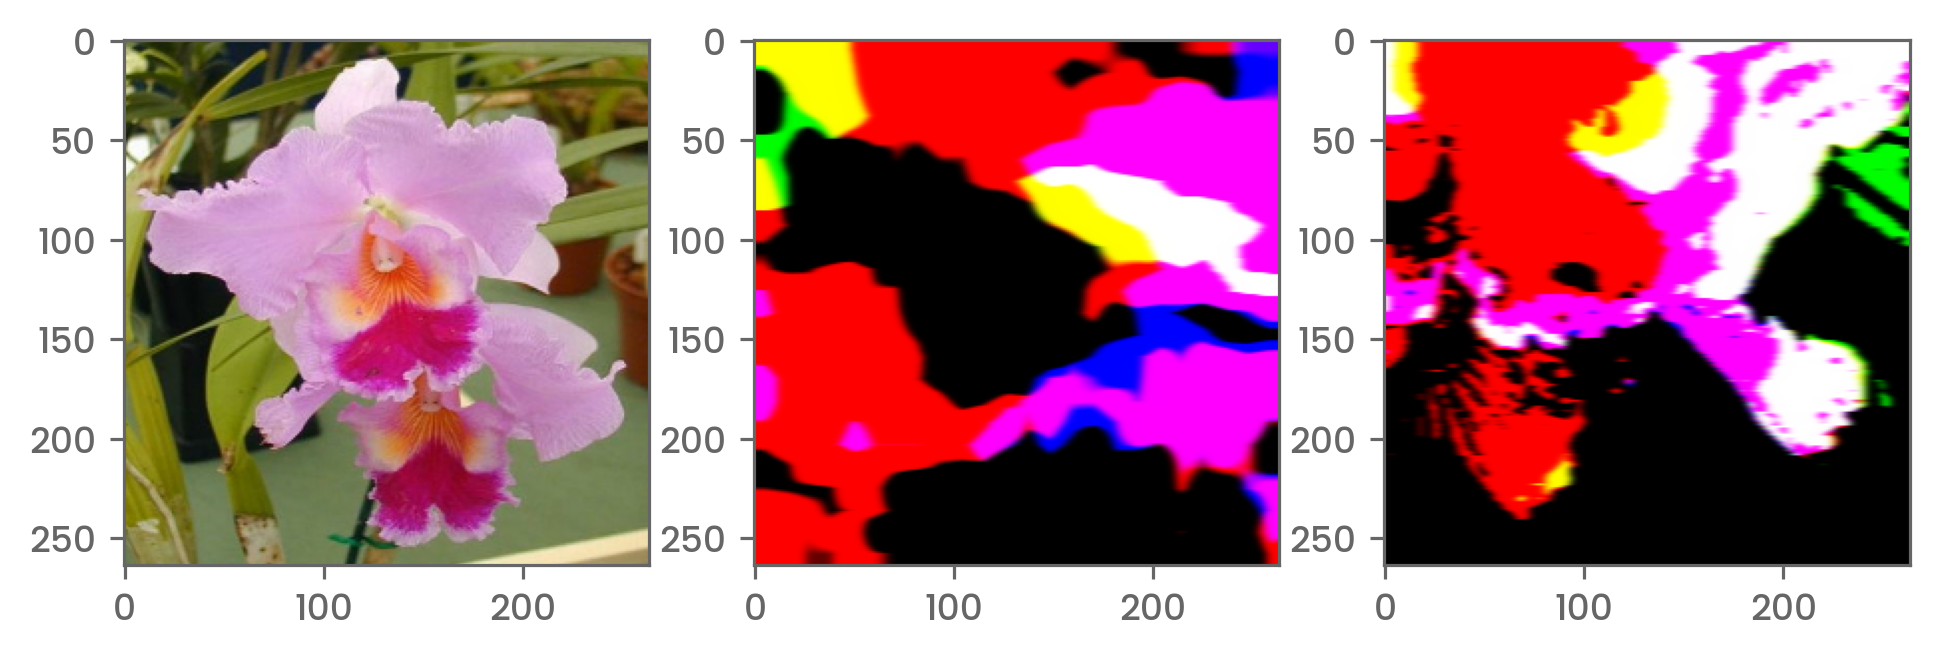

In [135]:
display_ds = train_prep_ds.map(lambda x,y: (make_display_input(x), y))
itr = display_ds.shuffle(10).as_numpy_iterator()
(image, x1, x2), label = next(itr)
# (anchor, a_label), (positive, p_label), (negative, n_label) = next(itr)

def display(display_list, cols=2, size=(8, 8)):
    rows = (len(display_list) + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=size)

    def get_axis(index):
        row, col = index//cols, index%cols
        return axes[row, col] if rows>1 else axes[col]
    
    for index, image in enumerate(display_list):
        axis = get_axis(index)
        axis.imshow(tf.keras.utils.array_to_img(image))

# itr = train_contrastive_ds.as_numpy_iterator()
# next(itr)
# (image1, _), (image2, _), (image3, _) = next(itr), next(itr), next(itr)
# image1, image2, image3 = tf.cast(image1, dtype=tf.int32), tf.cast(image2, dtype=tf.int32), tf.cast(image3, dtype=tf.int32)
# display([image1, image2, image3], cols=3)

display([image, x1, x2], cols=3)
print(label)
# print(a_label, p_label, n_label)

## Contrastive Learning Model

In [113]:
LEARNING_RATE = 0.0002
TEMPERATURE = 1.0

def nt_xent_loss(_, z):
    N = tf.shape(z)[0]//2
    similarity = tf.keras.losses.CosineSimilarity(-1, tf.keras.losses.Reduction.NONE)

    def exp_similarity(i, j):
        return tf.math.exp(similarity(z[i], z[j]) / TEMPERATURE)

    def item_loss(i, j):
        positive_loss = exp_similarity(i, j)
        negative_loss = 0.0

        for k in range(2*N):
            if k == i: continue
            negative_loss += exp_similarity(i, k)
        
        loss = -tf.math.log(positive_loss/negative_loss)
        return loss
        
    loss = 0.0
    for p in range(N):
        loss += (item_loss(2*p, 2*p+1) + item_loss(2*p+1, 2*p))

    normalized_loss = loss/(2.0*tf.cast(N, dtype=tf.float32))

    return normalized_loss

# def create_contrastive_learning_model():
#   # Initalize the core model
#   resnet_args = dict(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
#   resnet = apps.resnet50.ResNet50(**resnet_args)

#   # ResNet encoder
#   features = tf.keras.Sequential(
#     [
#       layers.Lambda(lambda x: apps.resnet.preprocess_input(x)),
#       resnet,
#       layers.AveragePooling2D(),
#     ],
#     name='features'
#   )

#   # Feature Projection
#   projection = tf.keras.Sequential(
#     [
#       layers.Dense(2048),
#       layers.BatchNormalization(),
#       layers.Activation('relu'),
#       layers.Dense(2048)
#     ],
#     name='projection')

#   # Contrastive Inputs
#   contrastive_input = layers.Input([2, IMG_SIZE, IMG_SIZE, 3], dtype = tf.uint8)
#   x1, x2 = tf.unstack(contrastive_input, axis=1)
#   x1, x2 = features(x1), features(x2)
#   x1, x2 = projection(x1), projection(x2)
#   output = tf.stack([x1, x2], axis=1)

#   simclr = tf.keras.Model(inputs=[contrastive_input], outputs=output)
#   adam = optimizers.Adam(learning_rate=LEARNING_RATE)

#   simclr.compile(optimizer=adam, loss=nt_xent_loss)
#   return simclr

def create_contrastive_learning_model():
  # Initalize the core model
  resnet_args = dict(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
  resnet = apps.resnet50.ResNet50(**resnet_args)

  # ResNet encoder
  features = tf.keras.Sequential(
    [
      layers.Lambda(lambda x: apps.resnet.preprocess_input(x)),
      resnet,
      layers.GlobalAveragePooling2D(),
    ],
    name='features'
  )

  # Feature Projection
  projection = tf.keras.Sequential(
    [
      layers.Dense(2048),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.Dense(2048)
    ],
    name='projection')

  # Contrastive Inputs
  inp = layers.Input([IMG_SIZE, IMG_SIZE, 3], dtype = tf.uint8)
  x = features(inp)
  x = projection(x)

  simclr = tf.keras.Model(inputs=[inp], outputs=x)
  adam = optimizers.Adam(learning_rate=LEARNING_RATE)

  simclr.compile(optimizer=adam, loss=nt_xent_loss)
  return simclr

cl_model = create_contrastive_learning_model()
cl_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 264, 264, 3)]     0         
                                                                 
 features (Sequential)       (None, 2048)              23587712  
                                                                 
 projection (Sequential)     (None, 2048)              8400896   
                                                                 
Total params: 31,988,608
Trainable params: 31,931,392
Non-trainable params: 57,216
_________________________________________________________________


## APIs to plot training metrics

In [136]:
def plot_loss(h):
    fig = plt.figure()
    ax = fig.gca()

    ax.plot(h['loss'], label='Loss')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Losses')

    ax.legend()

## Train the contrastive model

In [ ]:
# BATCH_SIZE = 24
# EPOCHS = 30
BATCH_SIZE = 2
EPOCHS = 1
CONTRASTIVE_LEARNING_MODEL = 'contrastive_learning_model.h5'

# if not Path(CONTRASTIVE_LEARNING_MODEL).exists():
#     ! wget "https://www.dropbox.com/s/bbv4dakqg45ctty/contrastive_learning_model.h5?dl=1" -O $CONTRASTIVE_LEARNING_MODEL

#     print('Loading the pre-trained contrastive learning model...')
#     cl_model.load_weights(CONTRASTIVE_LEARNING_MODEL)

print('Training the contrastive learning model')
tds = train_contrastive_ds.batch(BATCH_SIZE).take(1)
hist = cl_model.fit(tds, epochs=EPOCHS)
plot_loss(hist.history), print(hist.history)

print('Saving the constrastive learning model as:', CONTRASTIVE_LEARNING_MODEL)
cl_model.save_weights(CONTRASTIVE_LEARNING_MODEL)